In [177]:
%matplotlib inline

In [178]:
import pandas as pd
import missingno as msno
import numpy as np

In [179]:
# Read data
data = pd.read_csv("../docs/dataset_NB.csv")
data.dtypes

email    object
label     int64
dtype: object

In [180]:
data.head(10)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
5,i just had to jump in here as carbonara is on...,0
6,the scotsman NUMBER august NUMBER playboy want...,0
7,martin adamson wrote isn t it just basically a...,0
8,the scotsman thu NUMBER aug NUMBER meaningful ...,0
9,i have been trying to research via sa mirrors ...,0


In [181]:
data.tail(10)

,email,label
2990,get NUMBER free vhs or dvds click hyperlink h...,1
2991,get NUMBER free vhs or dvds click hyperlink h...,1
2992,wealth without risk discover the best kept se...,1
2993,attn sir madan strictly confidential i am plea...,1
2994,from mr desmond stevens urgent assistance you...,1
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1
2999,hello this is chinese traditional 子 件 NUMBER世...,1



Our data has two columns:

    A column containing the email text with the title "email".
    A column with the Spam Indicator with the title "label". This has a value of 1 when the email is spam.

Looking at the top and bottom of the dataset, it is evident that our non Spam emails are at the beginning of the dataset, and the Spam emails are at the bottom.

## Data Preprocessing

In [182]:
data = data.dropna(subset=["email"])

In [183]:
data = data.drop_duplicates()

In [184]:
import re

# Remove numbers, punctuation, and special characters from the `email` column
# These usually don't carry much semantic meaning and can confuse the model.
data["email"] = data["email"].apply(lambda x: re.sub(r"[^a-z\s]", "", x))

In [185]:
# Convert the `email` column to lowercase
# This ensures that words like "Free" and "free" are treated the same.
data["email"] = data["email"].str.lower()

In [186]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")


# converts words to their dictionary form (lemma) (e.g., "better" becomes "good").
# Improves model performance by reducing dimensionality and treating similar words as one
def lemmatize(text):
    """Lemmatizes the words in the input text.

    Args:
        text (str): The text to lemmatize.

    Returns:
        str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


data["email"] = data["email"].apply(lemmatize)

[nltk_data] Downloading package wordnet to /home/vandy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [187]:
data["email"].head(10)

0    date wed aug from chris garrigues cwg dated fa...
1    martin a posted tasso papadopoulos the greek s...
2    man threatens explosion in moscow thursday aug...
3    klez the virus that won t die already the most...
4    in adding cream to spaghetti carbonara which h...
5    i just had to jump in here a carbonara is one ...
6    the scotsman august playboy want to go out wit...
7    martin adamson wrote isn t it just basically a...
8    the scotsman thu aug meaningful sentence trace...
9    i have been trying to research via sa mirror a...
Name: email, dtype: object

## Feature Engineering

In [188]:
# Create email length feature.
# Getting much less false positives.
data["email_length"] = data["email"].apply(len)

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform the text data into a matrix of TF-IDF features

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

vectorizer = TfidfVectorizer(
    max_df=0.8,  # Ignore words that appear in more than 80% of emails
    min_df=5,  # Ignore words that appear in fewer than 5 emails
    ngram_range=(1, 2),  # Include both unigrams and bigrams as features
    stop_words="english",  # Remove common English stop words
)

X_tfidf = vectorizer.fit_transform(data["email"])

**Reasoning**

1. max_df=0.8: This will help to remove very common words that are likely to appear in both spam and non-spam emails (e.g., "the," "a," "is," etc.). By setting it to 0.8, we ignore words that appear in more than 80% of the emails.
2. min_df=5: This will help to remove very rare words that are unlikely to be helpful for classification. These could be typos or very specific terms that only occur a few times.
3. ngram_range=(1,2): Including bigrams (two-word sequences) in addition to unigrams (single words) can sometimes capture more meaningful phrases that are indicative of spam or non-spam. For example, "free offer" or "click here."
4. stop_words='english': This is a common preprocessing step in text analysis. Stop words are frequent words that carry little semantic meaning (e.g., "the," "a," "is," "to"). Removing them can reduce the dimensionality of your data and potentially improve model performance.

In [190]:
from scipy.sparse import hstack

X_extra = data[["email_length"]]  # Select the extra feature columns
X_combined = hstack((X_tfidf, X_extra))
# X_combined = X_tfidf

## Fitting the model.

In [191]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, data["label"], test_size=0.2, random_state=42
)

In [192]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train.toarray(), y_train)  # Convert to dense array if needed

GaussianNB()

Accuracy: 96.87%


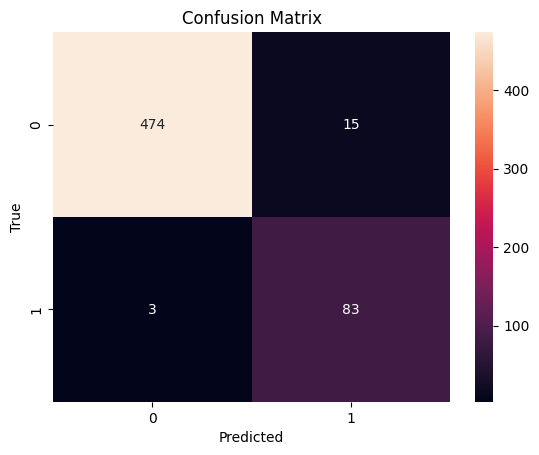

In [193]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test.toarray())  # Convert to dense array if needed
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Briefly explain the approach, any preprocessing, explain the output, any visualization for explanation, any feature extraction.

The code implements a Naive Bayes classifier to predict whether an email is spam or not (ham). It uses a combination of text preprocessing, feature engineering, and machine learning to achieve this.

**Preprocessing**

The email text data is preprocessed to clean and standardize it:

- Removing noise: Numbers, punctuation, and special characters are removed, as they usually don't contribute much to the meaning.
- Lowercasing: All text is converted to lowercase to treat words like "Free" and "free" the same.
- Lemmatization: Words are converted to their base dictionary form (lemma) using WordNetLemmatizer. For example, "running" becomes "run." This helps to group similar words together.

**Feature Extraction**

Two main types of features are extracted:

- TF-IDF features: The TfidfVectorizer converts the preprocessed text into numerical representations (TF-IDF scores) that capture the importance of words in each email relative to the entire dataset. Parameters like max_df, min_df, ngram_range, and stop_words are used to fine-tune this process.
- Email length: The length of each email (number of characters) is also included as a feature.

**Model Training and Evaluation**

- Train-test split: The data is split into training and testing sets to evaluate the model's performance on unseen data.
- Gaussian Naive Bayes: A GaussianNB classifier is trained on the training data.
- Prediction and accuracy: The trained model predicts the labels for the test data, and the accuracy score is calculated to measure the overall correctness of the predictions.
- Confusion matrix: A confusion matrix is plotted using seaborn to visualize the types of errors made by the model (e.g., how many spam emails were classified as ham, and vice versa).